### "Проверка системы сплитования"

In [1]:
# Импорт  библиотек
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
from scipy.stats import ttest_ind
%matplotlib inline

Разбиваем пользователей на группы с помощью хэширования с солью.

In [4]:
# хэширование с солью
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

Разбиение по соленому хэшу гарантирует, что получившиеся группы будут случайны и приблизительно одинакового размера.

In [5]:
# разбиение их по соленому хэшу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '*****',
    'user': 'student',
    'database': 'simulator_20250820'
}

q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-07-26' and toDate(time) <= '2025-08-01' 
"""

# Вытащим пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

# Сделаем группы
users_df['hash_group'] = users_df.user_id.swifter.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

Pandas Apply:   0%|          | 0/41997 [00:00<?, ?it/s]

,hash_group,user_id
0,0,8588
1,1,8254
2,2,8397
3,3,8305
4,4,8453


Хэшировать можно и прямо в кликхаусе:

In [6]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-07-26' and toDate(time) <= '2025-08-01' 
group by group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,8452
1,1,8326
2,2,8395
3,3,8492
4,4,8332


Проверка корректности работы системы сплитования

In [8]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-07-26' and '2025-08-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


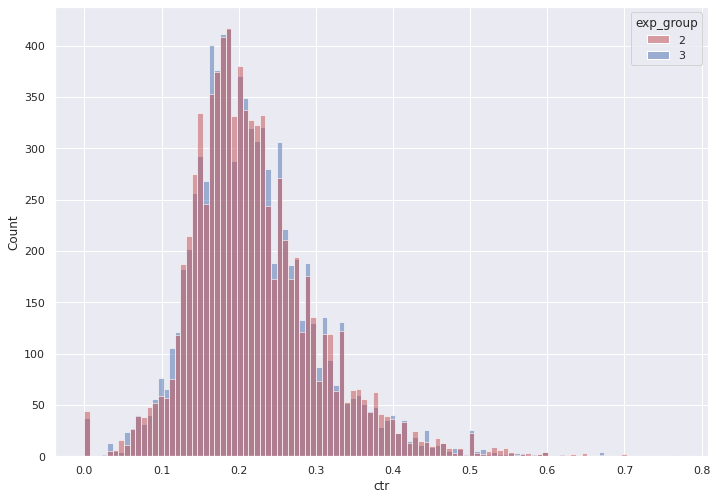

In [9]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально распределения группы 2 и 3 почти одинаковы.

Удостоверимся что группы, на которые мы разбили пользователей, не отличаются друг от друга, с помощью А/А-теста.

In [10]:
# из групп 2 и 3 берём подвыборки без возвращения размером в 500 юзеров и проведем t-test Стьюдента

p_values = []

for _ in range(10000):
    sample_2 = df[df.exp_group == 2].sample(500, replace=False)
    sample_3 = df[df.exp_group == 3].sample(500, replace=False)
    
    # Выполнение t-теста
    t_stat, p_value = ttest_ind(sample_2['ctr'], sample_3['ctr'], equal_var=False)
    
    # Сохранение p-value
    p_values.append(p_value)

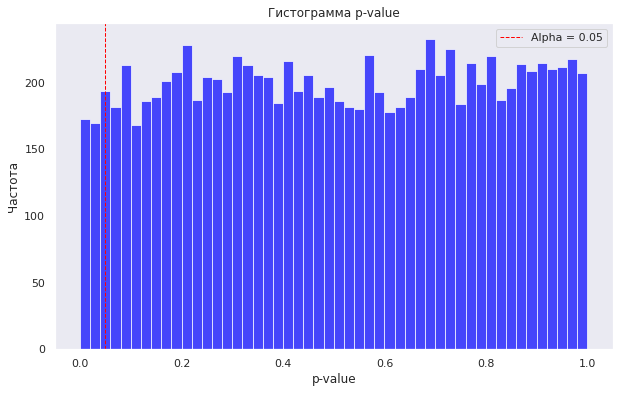

In [11]:
# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(p_values, bins=50, color='blue', alpha=0.7)
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1, label='Alpha = 0.05')
plt.title('Гистограмма p-value')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.legend()
plt.grid()
plt.show()

In [12]:
# подсчет доли p-value ниже 0.05
significant_count = sum(p < 0.05 for p in p_values)
total_count = len(p_values)
proportion_significant = significant_count / total_count

print(f'Доля p-value ниже 0.05: {proportion_significant: .3f}')

Доля p-value ниже 0.05:  0.044


**Вывод:**  
распределение получившихся p-value является примерно равномерным, доля p-value ниже порога значимости составляет 0.044. Это примерно столько, сколько мы ожидаем. Значит, система сплитования работает корректно.